<h1>Car Price Prediction</h1>

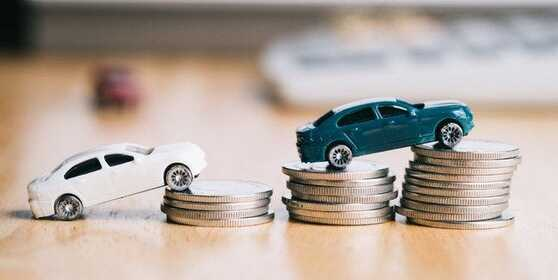

<h2><b style="color: green"> PURPOSE:</b> The purpose of this competition is to guess the price of a car using its characteristics.
    Not all characteristics can be used when predicting the price. 
    Make predictions using machine learning algorithms or deep learning networks.</h2>
    
<h2><b style="color: blue"> EVALUATION:</b> The evaluation criterion for this competition is the Mean Absolute Error, which calculates the modulus of the difference between the predicted value and the actual value for all data and returns the mean of the sum.
MSE will be calculated between the submit prediction and the actual price.</h2>

# 1. *IMPORTS*

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector

In [19]:
train_car = pd.read_csv('/kaggle/input/autoam-car-price-prediction/train.csv')
train_car.sample(10)

,model,year,motor_type,running,wheel,color,type,status,motor_volume,price
1337,mercedes-benz,1995,gas,222000 km,left,white,sedan,good,1.8,4500
1539,nissan,2017,petrol,58000 miles,left,white,Universal,excellent,2.5,18700
1592,kia,2018,gas,83000 miles,left,red,Universal,excellent,2.0,14900
228,hyundai,2018,petrol,55000 miles,left,red,sedan,excellent,2.0,13400
373,nissan,2017,petrol,85000 km,left,black,suv,excellent,2.0,18500
1056,toyota,2012,petrol,110000 miles,left,white,sedan,excellent,2.0,13500
144,kia,2021,petrol,12900 miles,left,blue,sedan,excellent,2.0,19000
818,hyundai,2013,petrol,124000 miles,left,white,sedan,good,2.0,10000
366,mercedes-benz,1998,gas,416500 km,left,blue,sedan,good,2.0,5500
1244,hyundai,2014,petrol,72000 miles,left,blue,sedan,good,1.8,10800


In [20]:
test_car = pd.read_csv('/kaggle/input/autoam-car-price-prediction/test.csv')
test_car.sample(10)

,Id,model,year,motor_type,running,wheel,color,type,status,motor_volume
288,288,nissan,2018,petrol,64000 miles,left,black,suv,excellent,2.5
19,19,kia,2014,petrol and gas,98000 miles,left,black,sedan,excellent,2.0
1,1,nissan,2017,petrol,85000 miles,left,white,suv,excellent,2.0
401,401,nissan,2020,petrol,120000 km,left,black,suv,excellent,2.0
181,181,toyota,2021,petrol,50000 km,left,black,sedan,excellent,2.0
329,329,mercedes-benz,2000,gas,320000 km,left,silver,sedan,good,2.0
107,107,kia,2019,petrol,61000 miles,left,gray,sedan,excellent,2.0
183,183,kia,2018,petrol,35700 miles,left,black,sedan,excellent,2.0
341,341,kia,2020,petrol,40000 miles,left,black,sedan,excellent,2.0
104,104,toyota,2009,petrol,123456 km,left,silver,sedan,good,2.0


# 2. *Data Visualization*

In [21]:
# Shape of each dataset

print(f"Shape for train_car is: {train_car.shape}\nShape for test_car is: {test_car.shape}")

Shape for train_car is: (1642, 10)
Shape for test_car is: (411, 10)


In [22]:
# Check for NaN Values

print(f"Number of NaN values in train_car is: {train_car.isna().sum().sum()}\nNumber of NaN values in train_car is: {test_car.isna().sum().sum()}")

Number of NaN values in train_car is: 0
Number of NaN values in train_car is: 0


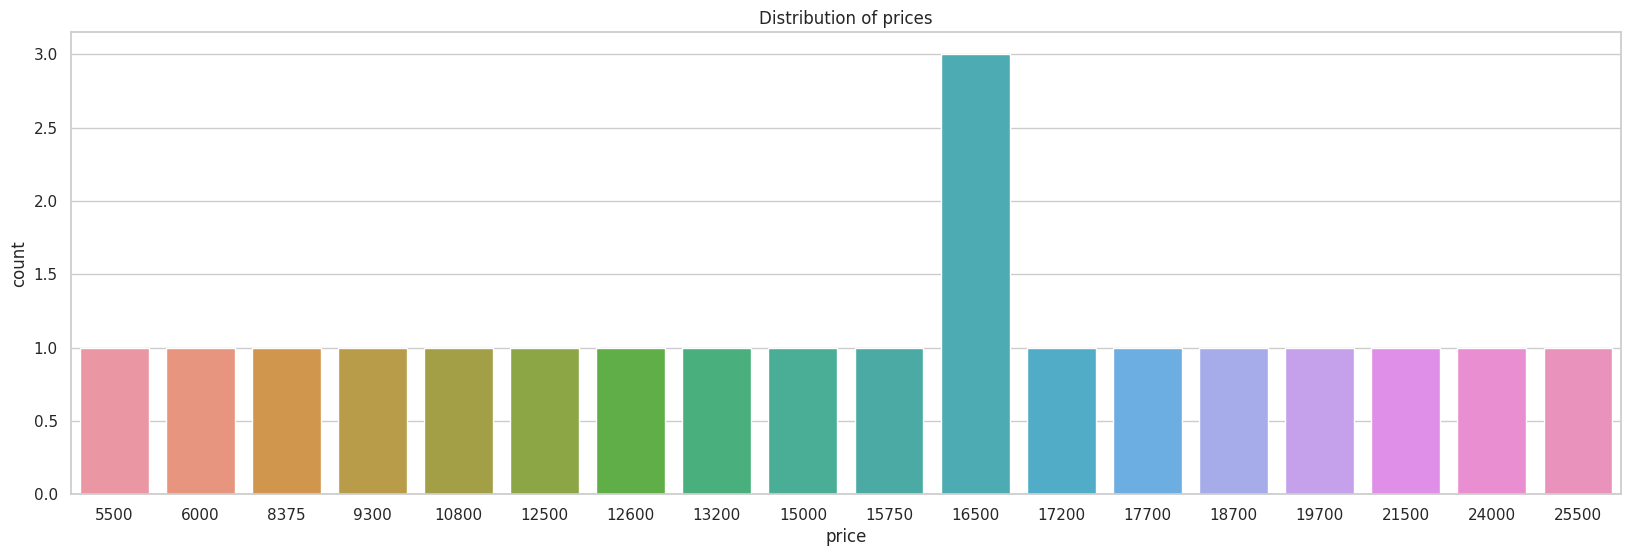

In [23]:
# EDA
plt.figure(figsize=(20, 6))
sns.countplot(x = 'price', data = train_car[40:60])
plt.title('Distribution of prices')
plt.show()

# 3. *Data Cleaning and Preprocessing*

In [24]:
# convert 'running' column values into a common one (km -> miles)

def convert_to_miles(running):
    if 'km' in running:
        return float(running.replace(' km', '').replace(',', '')) * 0.621371
    elif 'miles' in running:
        return float(running.replace(' miles', '').replace(',', ''))
    else:
        return None
# apply them
train_car['running_miles'] = train_car['running'].apply(convert_to_miles)
test_car['running_miles'] = test_car['running'].apply(convert_to_miles)

# drop the first ones
train_car.drop(columns=['running'], inplace=True)
test_car.drop(columns=['running'], inplace=True)

# show the updated datasets
train_car.head()

,model,year,motor_type,wheel,color,type,status,motor_volume,price,running_miles
0,toyota,2022,petrol,left,skyblue,sedan,excellent,2.0,24500,1864.113
1,mercedes-benz,2014,petrol,left,black,sedan,excellent,2.0,25500,82020.972
2,kia,2018,petrol,left,other,sedan,excellent,2.0,11700,95000.000
3,mercedes-benz,2002,petrol,left,golden,sedan,excellent,3.2,12000,137000.000
4,mercedes-benz,2017,petrol,left,black,sedan,good,2.0,26000,80778.230


In [25]:
test_car.head()

,Id,model,year,motor_type,wheel,color,type,status,motor_volume,running_miles
0,0,kia,2020,petrol,left,black,sedan,excellent,2.0,14912.904
1,1,nissan,2017,petrol,left,white,suv,excellent,2.0,85000.000
2,2,hyundai,2021,petrol,left,white,sedan,excellent,2.0,30000.000
3,3,kia,2018,petrol,left,silver,sedan,excellent,2.0,53000.000
4,4,mercedes-benz,2003,petrol,left,black,Universal,normal,1.8,142915.330


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

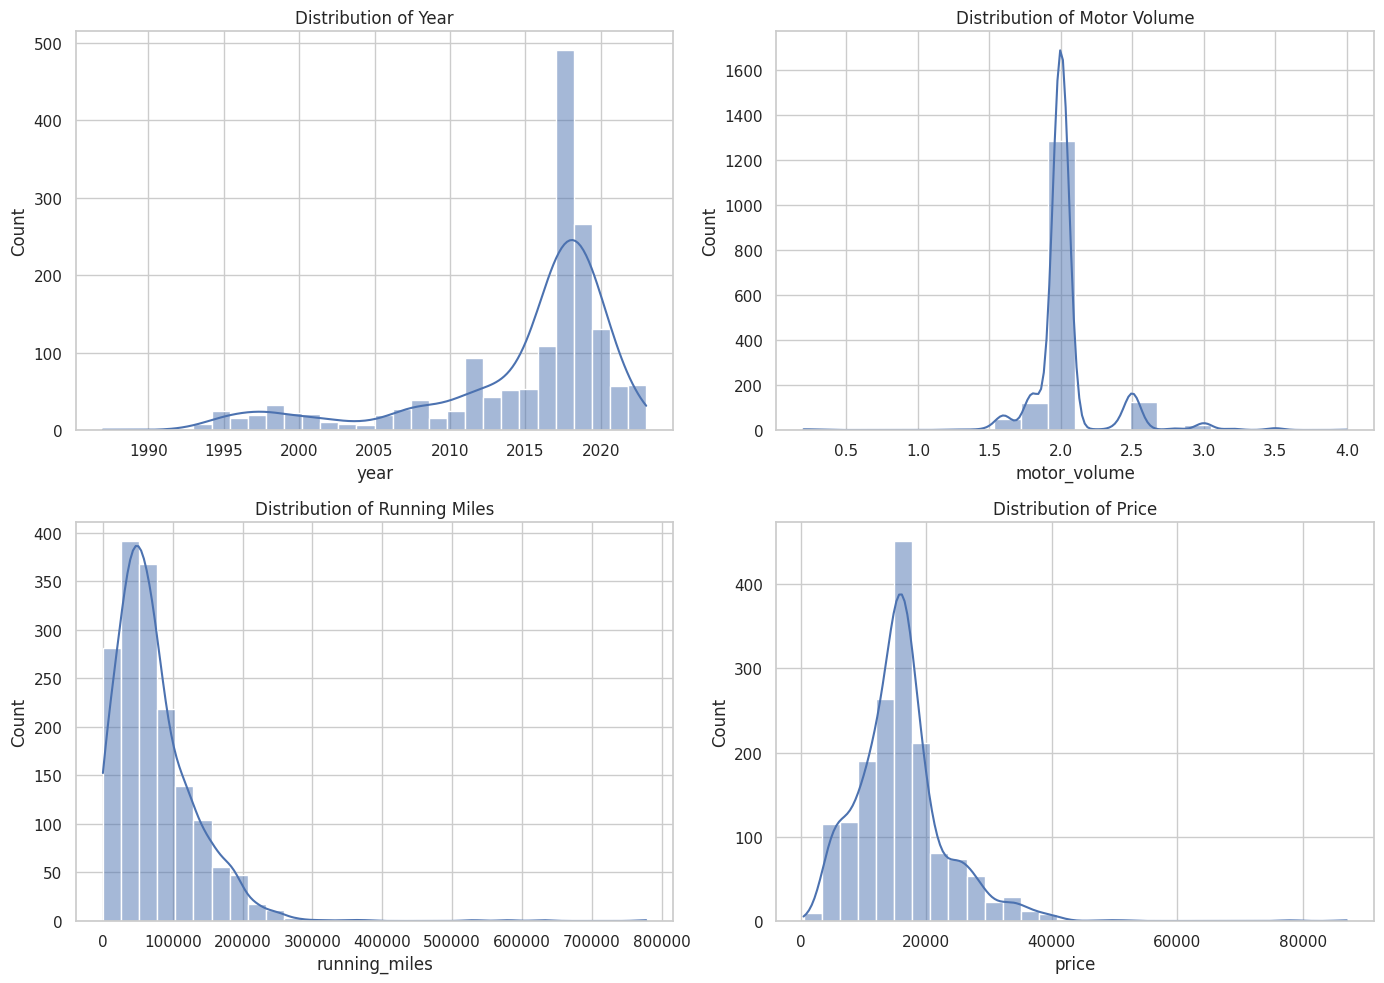

In [26]:
train_car.replace([np.inf, -np.inf], np.nan, inplace=True)

sns.set(style="whitegrid")


# create histograms for numerical variables
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 'year'
sns.histplot(train_car['year'], bins=30, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Year')

# 'motor_volume'
sns.histplot(train_car['motor_volume'], bins=20, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Motor Volume')

# 'running_miles'
sns.histplot(train_car['running_miles'], bins=30, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Running Miles')

# 'price'
sns.histplot(train_car['price'], bins=30, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Price')

plt.tight_layout()
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


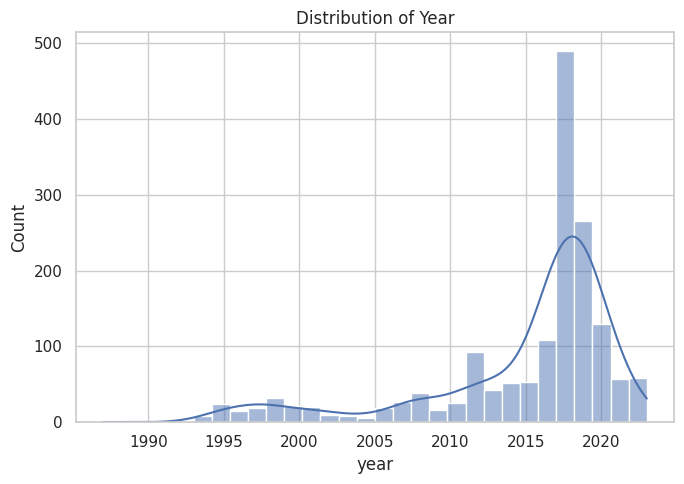

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# Create a subplot for 'year'
fig, ax = plt.subplots(figsize=(7, 5))

# Plot histogram
sns.histplot(train_car['year'], bins=30, kde=True, ax=ax)
ax.set_title('Distribution of Year')

plt.tight_layout()
plt.show()


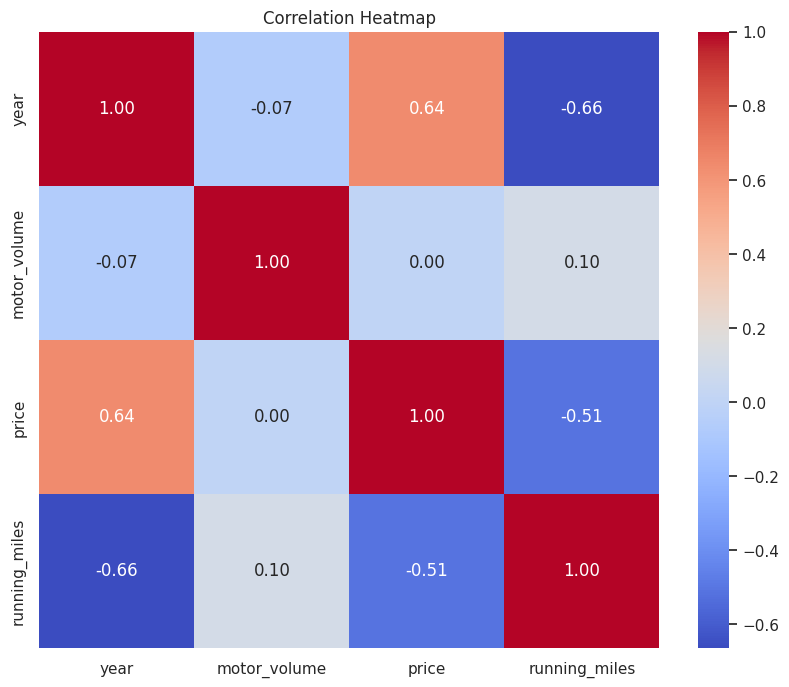

In [28]:
# correlation matrix

corr_matrix = train_car[['year', 'motor_volume', 'price', 'running_miles']].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show() # we can see that price and motor_volume has no correlation at all cause is 0

In [29]:
# Normalization
scaler = StandardScaler()
cols = ['year', 'motor_volume', 'running_miles']
train_car[cols] = scaler.fit_transform(train_car[cols])
test_car[cols] = scaler.transform(test_car[cols])

# 4. *Descriptive Statistics*

In [30]:
# mean, median, min, max, standard deviation for columns like year, motor_volume, running_miles, and price

# summary statistics of numerical columns
train_car.describe()

,year,motor_volume,price,running_miles
count,1.642000e+03,1.642000e+03,1642.000000,1.642000e+03
mean,3.712824e-15,5.895947e-17,15982.633374,6.923681e-17
std,1.000305e+00,1.000305e+00,7176.084647,1.000305e+00
min,-4.222222e+00,-7.253255e+00,462.000000,-1.232215e+00
25%,-2.741943e-01,-1.384163e-01,12000.000000,-6.500470e-01
50%,3.331946e-01,-1.384163e-01,15750.000000,-2.111335e-01
75%,6.368891e-01,-1.384163e-01,18500.000000,4.311052e-01
max,1.244278e+00,7.766960e+00,87000.000000,1.170702e+01


In [31]:
# frequency counts of categorical columns
train_car[['model', 'motor_type', 'wheel', 'color', 'type', 'status']].apply(pd.Series.value_counts)

,model,motor_type,wheel,color,type,status
Coupe,NaN,NaN,NaN,NaN,11.0,NaN
Universal,NaN,NaN,NaN,NaN,37.0,NaN
beige,NaN,NaN,NaN,5.0,NaN,NaN
black,NaN,NaN,NaN,541.0,NaN,NaN
blue,NaN,NaN,NaN,141.0,NaN,NaN
brown,NaN,NaN,NaN,10.0,NaN,NaN
cherry,NaN,NaN,NaN,20.0,NaN,NaN
clove,NaN,NaN,NaN,3.0,NaN,NaN
crashed,NaN,NaN,NaN,NaN,NaN,29.0
diesel,NaN,2.0,NaN,NaN,NaN,NaN


# 5. *Model training*

In [32]:
# checking which training with or without column motor_volume is better

# calculate correlation
correlation = train_car[['motor_volume', 'price']].corr().iloc[0, 1]
print("Correlation between motor_volume and price:", correlation)

Correlation between motor_volume and price: 0.0008853899033245035


In [33]:
# separate id from test_car

id_test = test_car[['Id']]
test_car = test_car.drop('Id', axis = 1)

In [34]:
# prepare the data
X = train_car.drop(columns=['price']) # training features
y = train_car['price'] # target / label
X

,model,year,motor_type,wheel,color,type,status,motor_volume,running_miles
0,toyota,1.092431,petrol,left,skyblue,sedan,excellent,-0.138416,-1.201306
1,mercedes-benz,-0.122347,petrol,left,black,sedan,excellent,-0.138416,0.132208
2,kia,0.485042,petrol,left,other,sedan,excellent,-0.138416,0.348132
3,mercedes-benz,-1.944514,petrol,left,golden,sedan,excellent,4.604810,1.046857
4,mercedes-benz,0.333195,petrol,left,black,sedan,good,-0.138416,0.111534
...,...,...,...,...,...,...,...,...,...
1637,hyundai,0.333195,petrol,left,white,sedan,good,-0.138416,0.764039
1638,toyota,-0.122347,petrol,left,black,sedan,good,-0.138416,0.525027
1639,nissan,0.485042,petrol,left,blue,suv,good,-0.138416,-0.086076
1640,nissan,0.636889,petrol,left,black,suv,excellent,-0.138416,-0.716592


In [35]:
# convert categorical variables to dummy variables
X = pd.get_dummies(X, dtype=int)
X

,year,motor_volume,running_miles,model_hyundai,model_kia,model_mercedes-benz,model_nissan,model_toyota,motor_type_diesel,motor_type_gas,...,type_hatchback,type_minivan / minibus,type_pickup,type_sedan,type_suv,status_crashed,status_excellent,status_good,status_new,status_normal
0,1.092431,-0.138416,-1.201306,0,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0
1,-0.122347,-0.138416,0.132208,0,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
2,0.485042,-0.138416,0.348132,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
3,-1.944514,4.604810,1.046857,0,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
4,0.333195,-0.138416,0.111534,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1637,0.333195,-0.138416,0.764039,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
1638,-0.122347,-0.138416,0.525027,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
1639,0.485042,-0.138416,-0.086076,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1640,0.636889,-0.138416,-0.716592,0,0,0,1,0,0,0,...,0,0,0,0,1,0,1,0,0,0


In [36]:
# get same columns
X_dummies = pd.get_dummies(X, dtype=int)
test_car_X_dummies = pd.get_dummies(test_car, dtype=int)

X_dummies, test_car_X_dummies = X_dummies.align(test_car_X_dummies, join='outer', axis=1, fill_value=0)

In [37]:
X_dummies

,color_beige,color_black,color_blue,color_brown,color_cherry,color_clove,color_golden,color_gray,color_green,color_orange,...,type_Coupe,type_Universal,type_hatchback,type_minivan / minibus,type_pickup,type_sedan,type_suv,wheel_left,wheel_right,year
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,1.092431
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,-0.122347
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0.485042
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,-1.944514
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0.333195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1637,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0.333195
1638,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,-0.122347
1639,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0.485042
1640,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0.636889


In [38]:
test_car_X_dummies

,color_beige,color_black,color_blue,color_brown,color_cherry,color_clove,color_golden,color_gray,color_green,color_orange,...,type_Coupe,type_Universal,type_hatchback,type_minivan / minibus,type_pickup,type_sedan,type_suv,wheel_left,wheel_right,year
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0.788736
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0.333195
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0.940584
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0.485042
4,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,-1.792667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0.940584
407,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0.333195
408,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,-0.426042
409,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0.788736


In [39]:
# split the data for cross validation
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, test_size=0.2, random_state=42)

In [40]:
# train the model

# params @Mikhail Naumov 
params = {'booster': 'gbtree',
          'max_depth': 3,
          'max_leaves': 769,
          'learning_rate': 0.04538451353216046,
          'n_estimators': 1171,
          'min_child_weight': 13,
          'subsample': 0.6578720167306904,
          'reg_alpha': 0.4622943878867952,
          'reg_lambda': 0.6211309481623339,
          'colsample_bylevel': 0.7985625445322192,
          'colsample_bytree': 0.9634723040072963,
          'colsample_bynode': 0.49814271378837316,
          'random_state': 42,
          'objective': 'reg:absoluteerror',
          'n_jobs': -1,
         }


model = XGBRegressor(**params)

# perform RandomizedSearchCV for parameter tuning
param_grid = {
    'max_depth': [3, 5, 7, 9, 11],  # Add more values if needed
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2],  
    'n_estimators': [100, 500, 1000, 1500, 2000],  
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5, 7, 10, 15],  
    'reg_alpha': [0.1, 0.3, 0.5, 1.0], 
    'reg_lambda': [0.5, 0.7, 0.9, 1.0, 1.2], 
    'colsample_bylevel': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'colsample_bynode': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4], 
}


rs_cv = RandomizedSearchCV(estimator=model, param_distributions=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, n_iter = 100, random_state = 42, verbose = 1)
rs_cv.fit(X_dummies, y)

# get the best model fromRandomizedSearchCV
best_model = rs_cv.best_estimator_

# print best parameters and cross-validated MAE
print("Best Parameters:", rs_cv.best_params_)
print("Best Cross-Validated MAE:", -rs_cv.best_score_)

best_model.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'subsample': 0.9, 'reg_lambda': 1.0, 'reg_alpha': 1.0, 'n_estimators': 1000, 'min_child_weight': 10, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6, 'colsample_bylevel': 0.6}
Best Cross-Validated MAE: 1934.3024065944014


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=0.6, colsample_bynode=0.6, colsample_bytree=1.0,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.3, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=769, min_child_weight=10, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=-1, num_parallel_tree=None, objective='reg:absoluteerror', ...)

In [41]:
y_pred_test = best_model.predict(X_test)
mae_test = mean_absolute_error(y_test, y_pred_test)

print("MAE:", mae_test)

MAE: 1924.6628046934366


In [42]:
# after training on X_train, y_train, train on the full dataset
best_model.fit(X_dummies, y)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=0.6, colsample_bynode=0.6, colsample_bytree=1.0,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.3, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=769, min_child_weight=10, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=-1, num_parallel_tree=None, objective='reg:absoluteerror', ...)

In [43]:
# perform cross-validation on full dataset
scores = cross_val_score(best_model, X_dummies, y, cv=5, scoring='neg_mean_absolute_error')
mae_scores = -scores

# print mean MAE across folds
print("Mean MAE (Cross-validated):", mae_scores.mean())

Mean MAE (Cross-validated): 1934.3024065944014


In [44]:
# predict for test_car
y_pred = best_model.predict(test_car_X_dummies)

print("id_test shape:", np.shape(id_test))
print("y_pred shape:", np.shape(y_pred))

id_test shape: (411, 1)
y_pred shape: (411,)


# 6. *Submission*

In [45]:
# flatten id_test to match y_pred
id_test_flat = np.array(id_test).flatten()

predictions = pd.DataFrame({"Id": id_test_flat, "price": y_pred})

print(predictions.head())

predictions.to_csv('predictions.csv', index=False)

   Id         price
0   0  17890.273438
1   1  17032.019531
2   2  23506.558594
3   3  14494.316406
4   4   6083.608887
